In [1]:
using Pkg
Pkg.activate("climate"; shared=true)

"/Users/imolk/Library/Julia/environments/climate/Project.toml"

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

Build the pipeline to get the data into STAN.

In [2]:
using CmdStan
using Printf
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData
using GaussianProcesses: Stationary, KernelData, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!
import Proj4
using Optim
using Distances
using DataFrames: by, head
using Dates: tonext, Hour, Day
using Distributions
using LinearAlgebra
using LinearAlgebra: I, eye, diag
;

In [3]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data import and preprocessing

In [4]:
using TempModel
include("iowa.jl")
data_dir = "../data"
iowa = prepare_iowa_data(data_dir);

  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41


# Visualizing Test Data: Tn and Tx

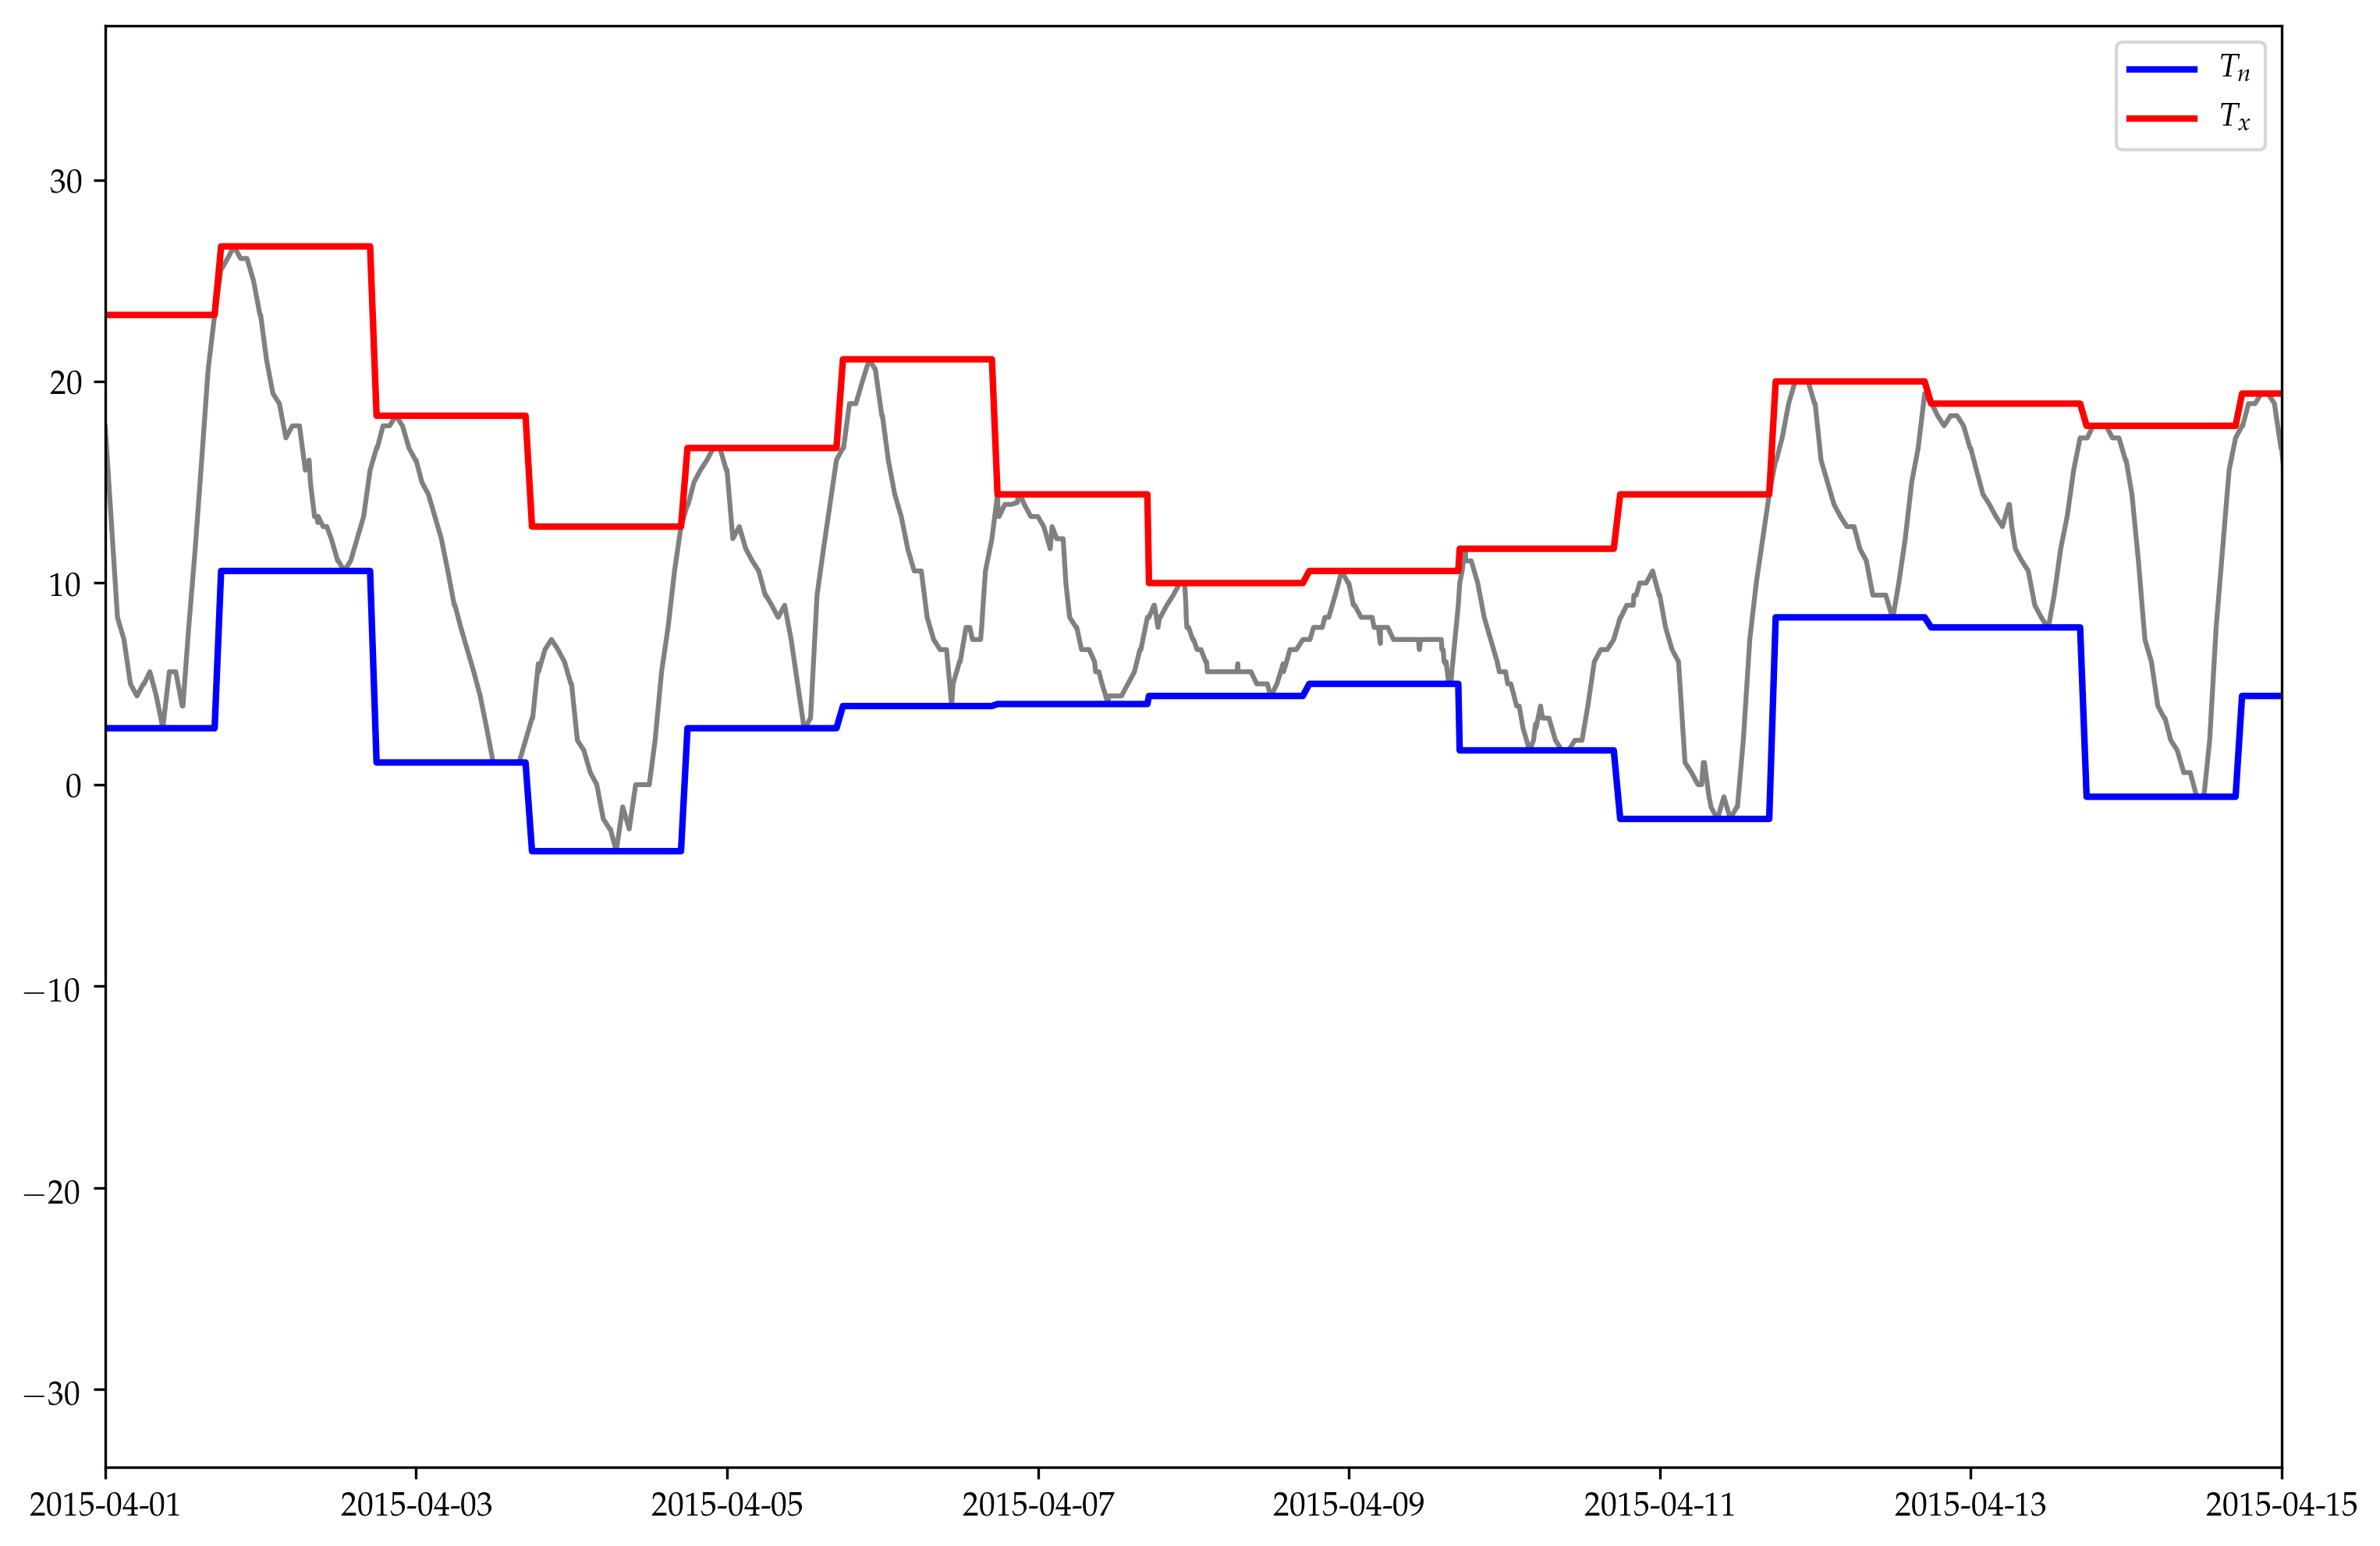

In [5]:
let
    test = iowa[:hourly_test]
    plt.plot(test[:ts], test[:temp], color="grey")
    plt.plot(test[:ts], test[:Tn], color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test[:ts], test[:Tx], color="red", linewidth=2, label=L"$T_x$")
    plt.xlim(DateTime(2015,4,1),DateTime(2015,4,15)) # random interval
    plt.legend()
end
;

# Kernel Specification

In [11]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_SExSE()

(Type: SumKernel{ProdKernel{Masked{SEIso{Float64},1},Masked{FixedKernel{SEIso{Float64},1},2}},FixedKernel{Masked{SEIso{Float64},2},0}}
  Type: ProdKernel{Masked{SEIso{Float64},1},Masked{FixedKernel{SEIso{Float64},1},2}}
    Type: Masked{SEIso{Float64},1}, Params: [0.996834, 1.3172]    Type: Masked{FixedKernel{SEIso{Float64},1},2}, Params: [12.0805]  Type: FixedKernel{Masked{SEIso{Float64},2},0}, Params: Float64[], -0.822261)

# Fitting GP on training data

In [7]:
dt_start, dt_end = DateTime(2015,5,25,18,0,0), DateTime(2015,6,3,16,0,0)
train_subset = TempModel.subset(iowa[:hourly_train], dt_start, dt_end)
test_subset  = TempModel.subset(iowa[:hourly_test],  dt_start, dt_end)

avgtemp=by(train_subset, :station, df->DataFrame(avgtemp=mean(df[:temp])))
train_subset = join(train_subset, avgtemp, on=:station)

train_X_PRJ = iowa[:isdSubset][:X_PRJ][train_subset[:station]]
train_Y_PRJ = iowa[:isdSubset][:Y_PRJ][train_subset[:station]]
train_X = [train_subset[:ts_hours] train_X_PRJ train_Y_PRJ]
train_Y = train_subset[:temp] .- train_subset[:avgtemp]

test_X_PRJ = iowa[:isdSubset][:X_PRJ][test_subset[:station]]
test_Y_PRJ = iowa[:isdSubset][:Y_PRJ][test_subset[:station]]
test_X = [test_subset[:ts_hours] test_X_PRJ test_Y_PRJ]
;

In [8]:
train_GP = GP(train_X', train_Y, MeanZero(), k_spatiotemporal, logNoise);

In [9]:
prior_GP = GP(zeros(3,0), zeros(0), MeanZero(), k_spatiotemporal, logNoise);

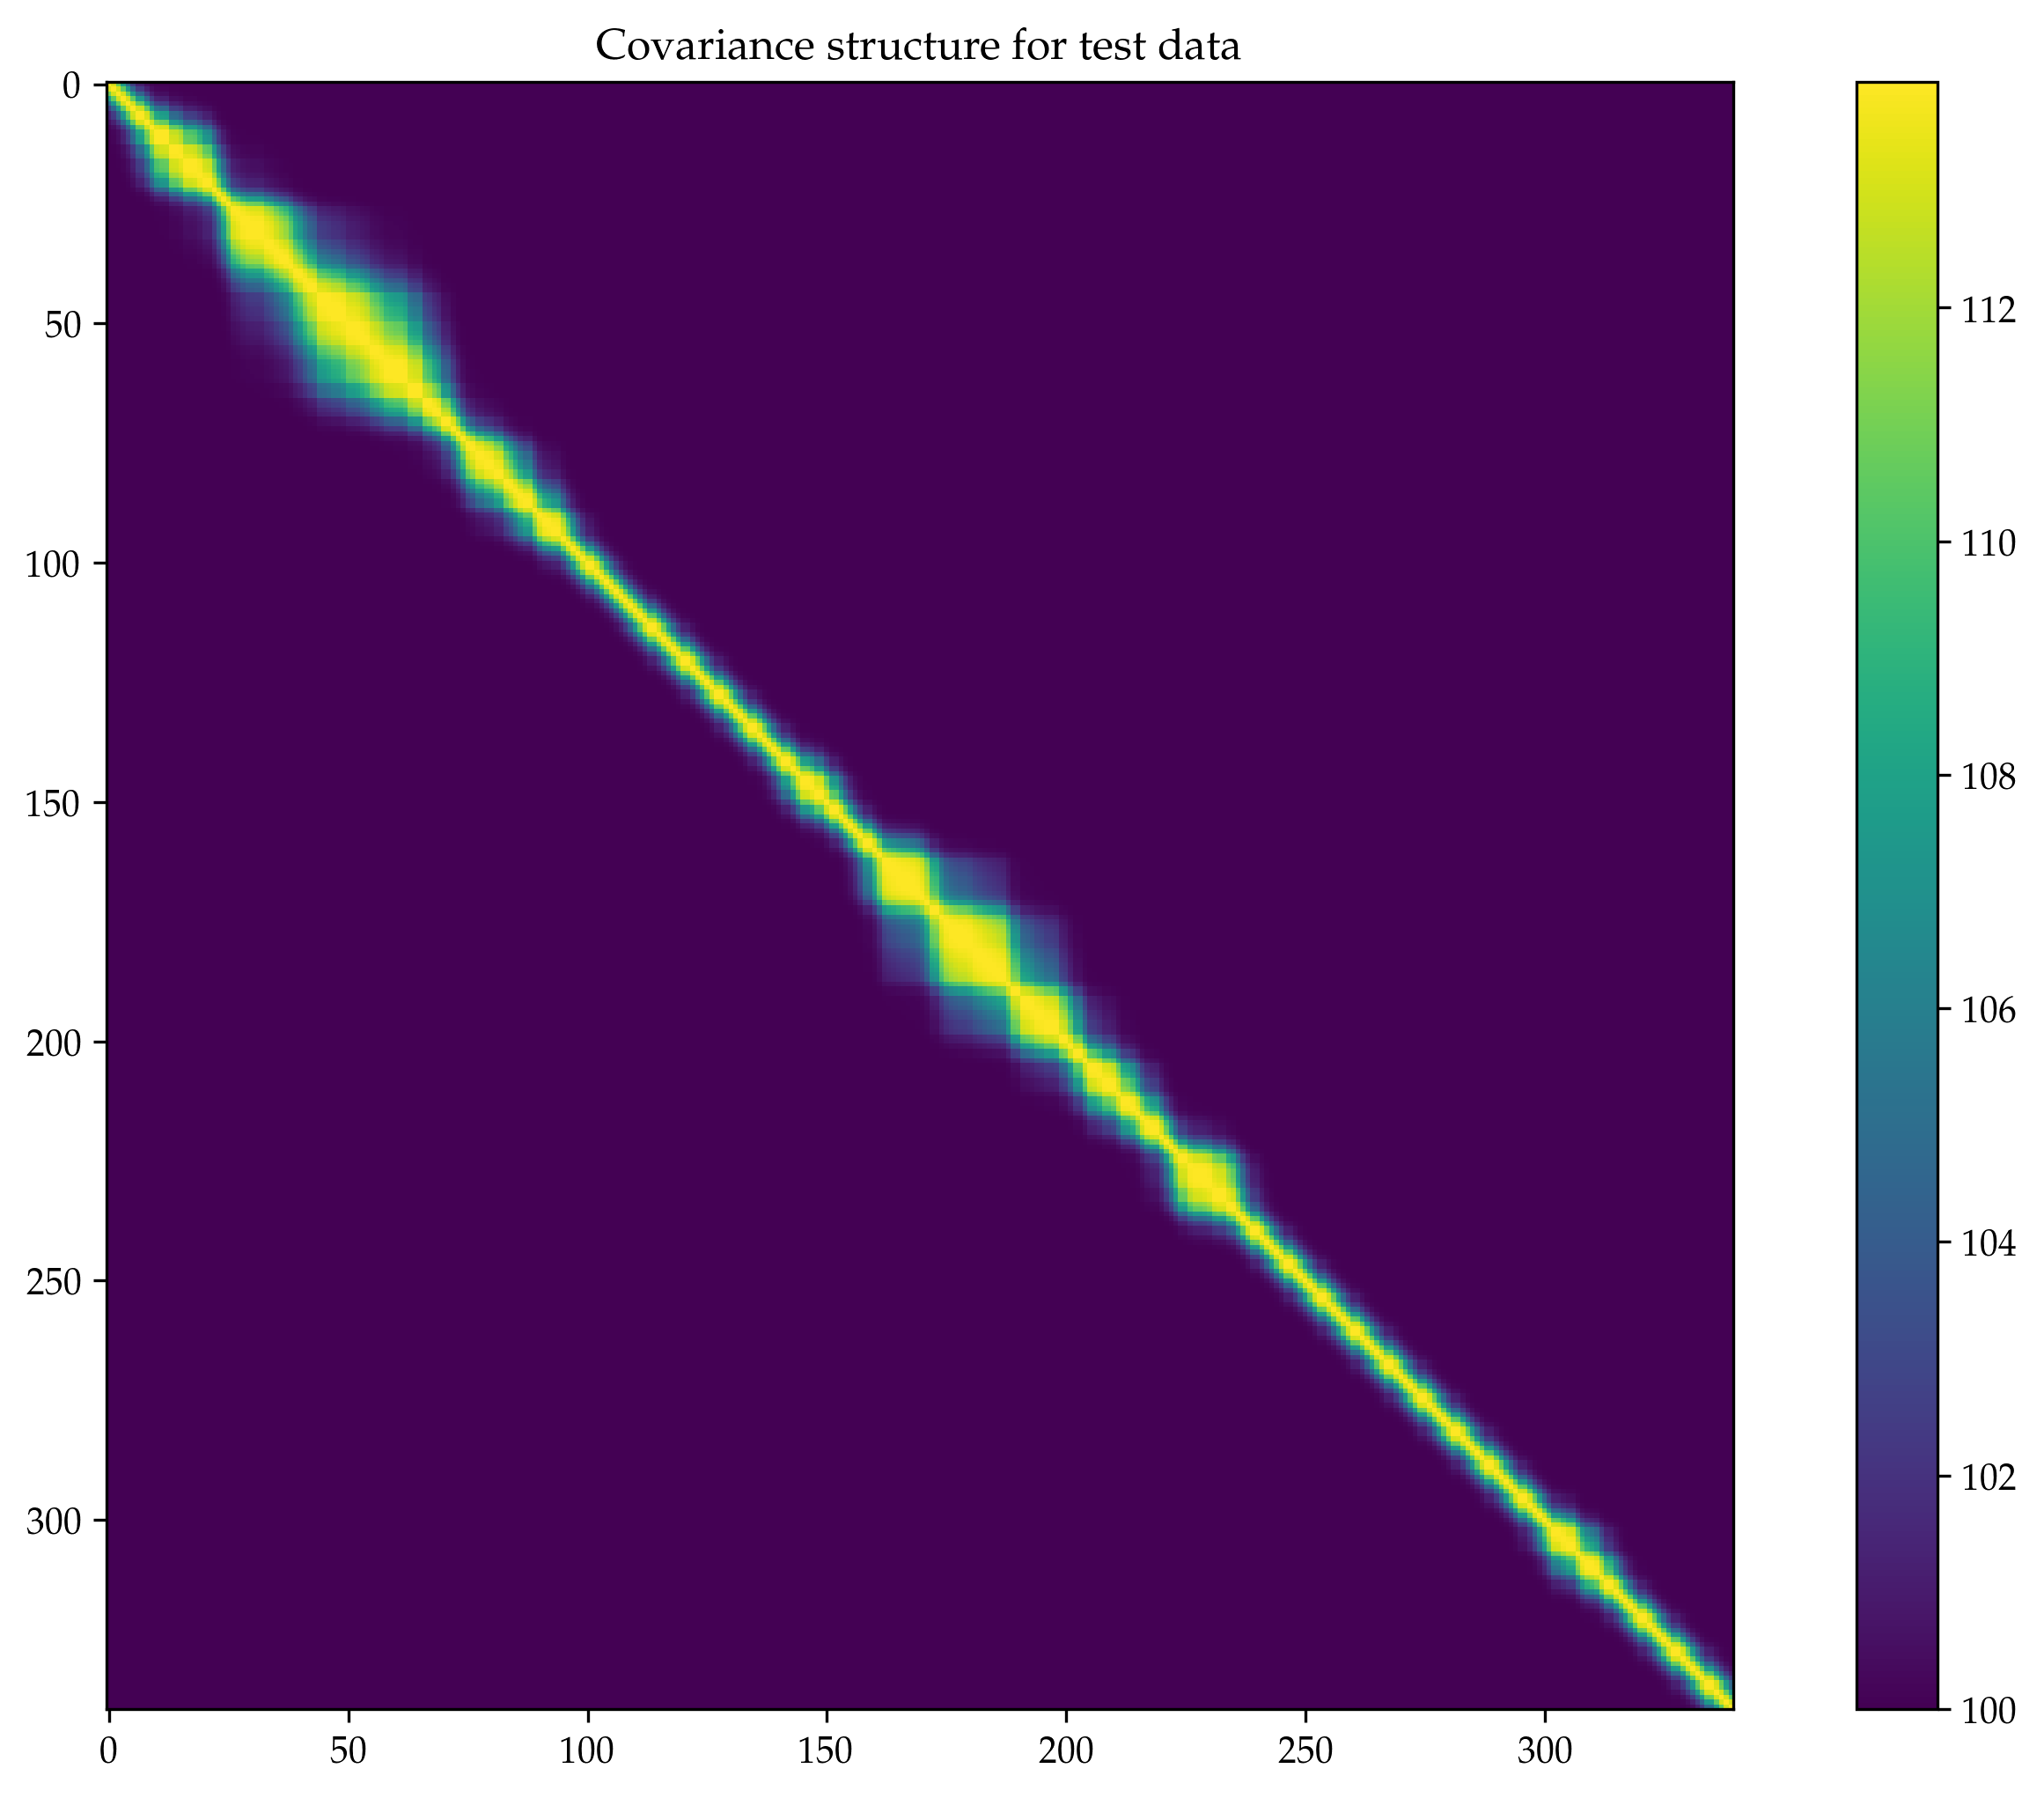

PyObject <matplotlib.colorbar.Colorbar object at 0x1400f3fd0>

In [10]:
plt.imshow(cov(k_spatiotemporal, test_X'))
plt.title("Covariance structure for test data")
plt.colorbar()

## Predicting at the test location

In [12]:
test_prediction=predict_f(train_GP, test_X'; full_cov=true)
prior_prediction=predict_f(prior_GP, test_X'; full_cov=true)
TempModel.add_diag!(test_prediction[2], exp(2*logNoise))
TempModel.add_diag!(prior_prediction[2], exp(2*logNoise))
;

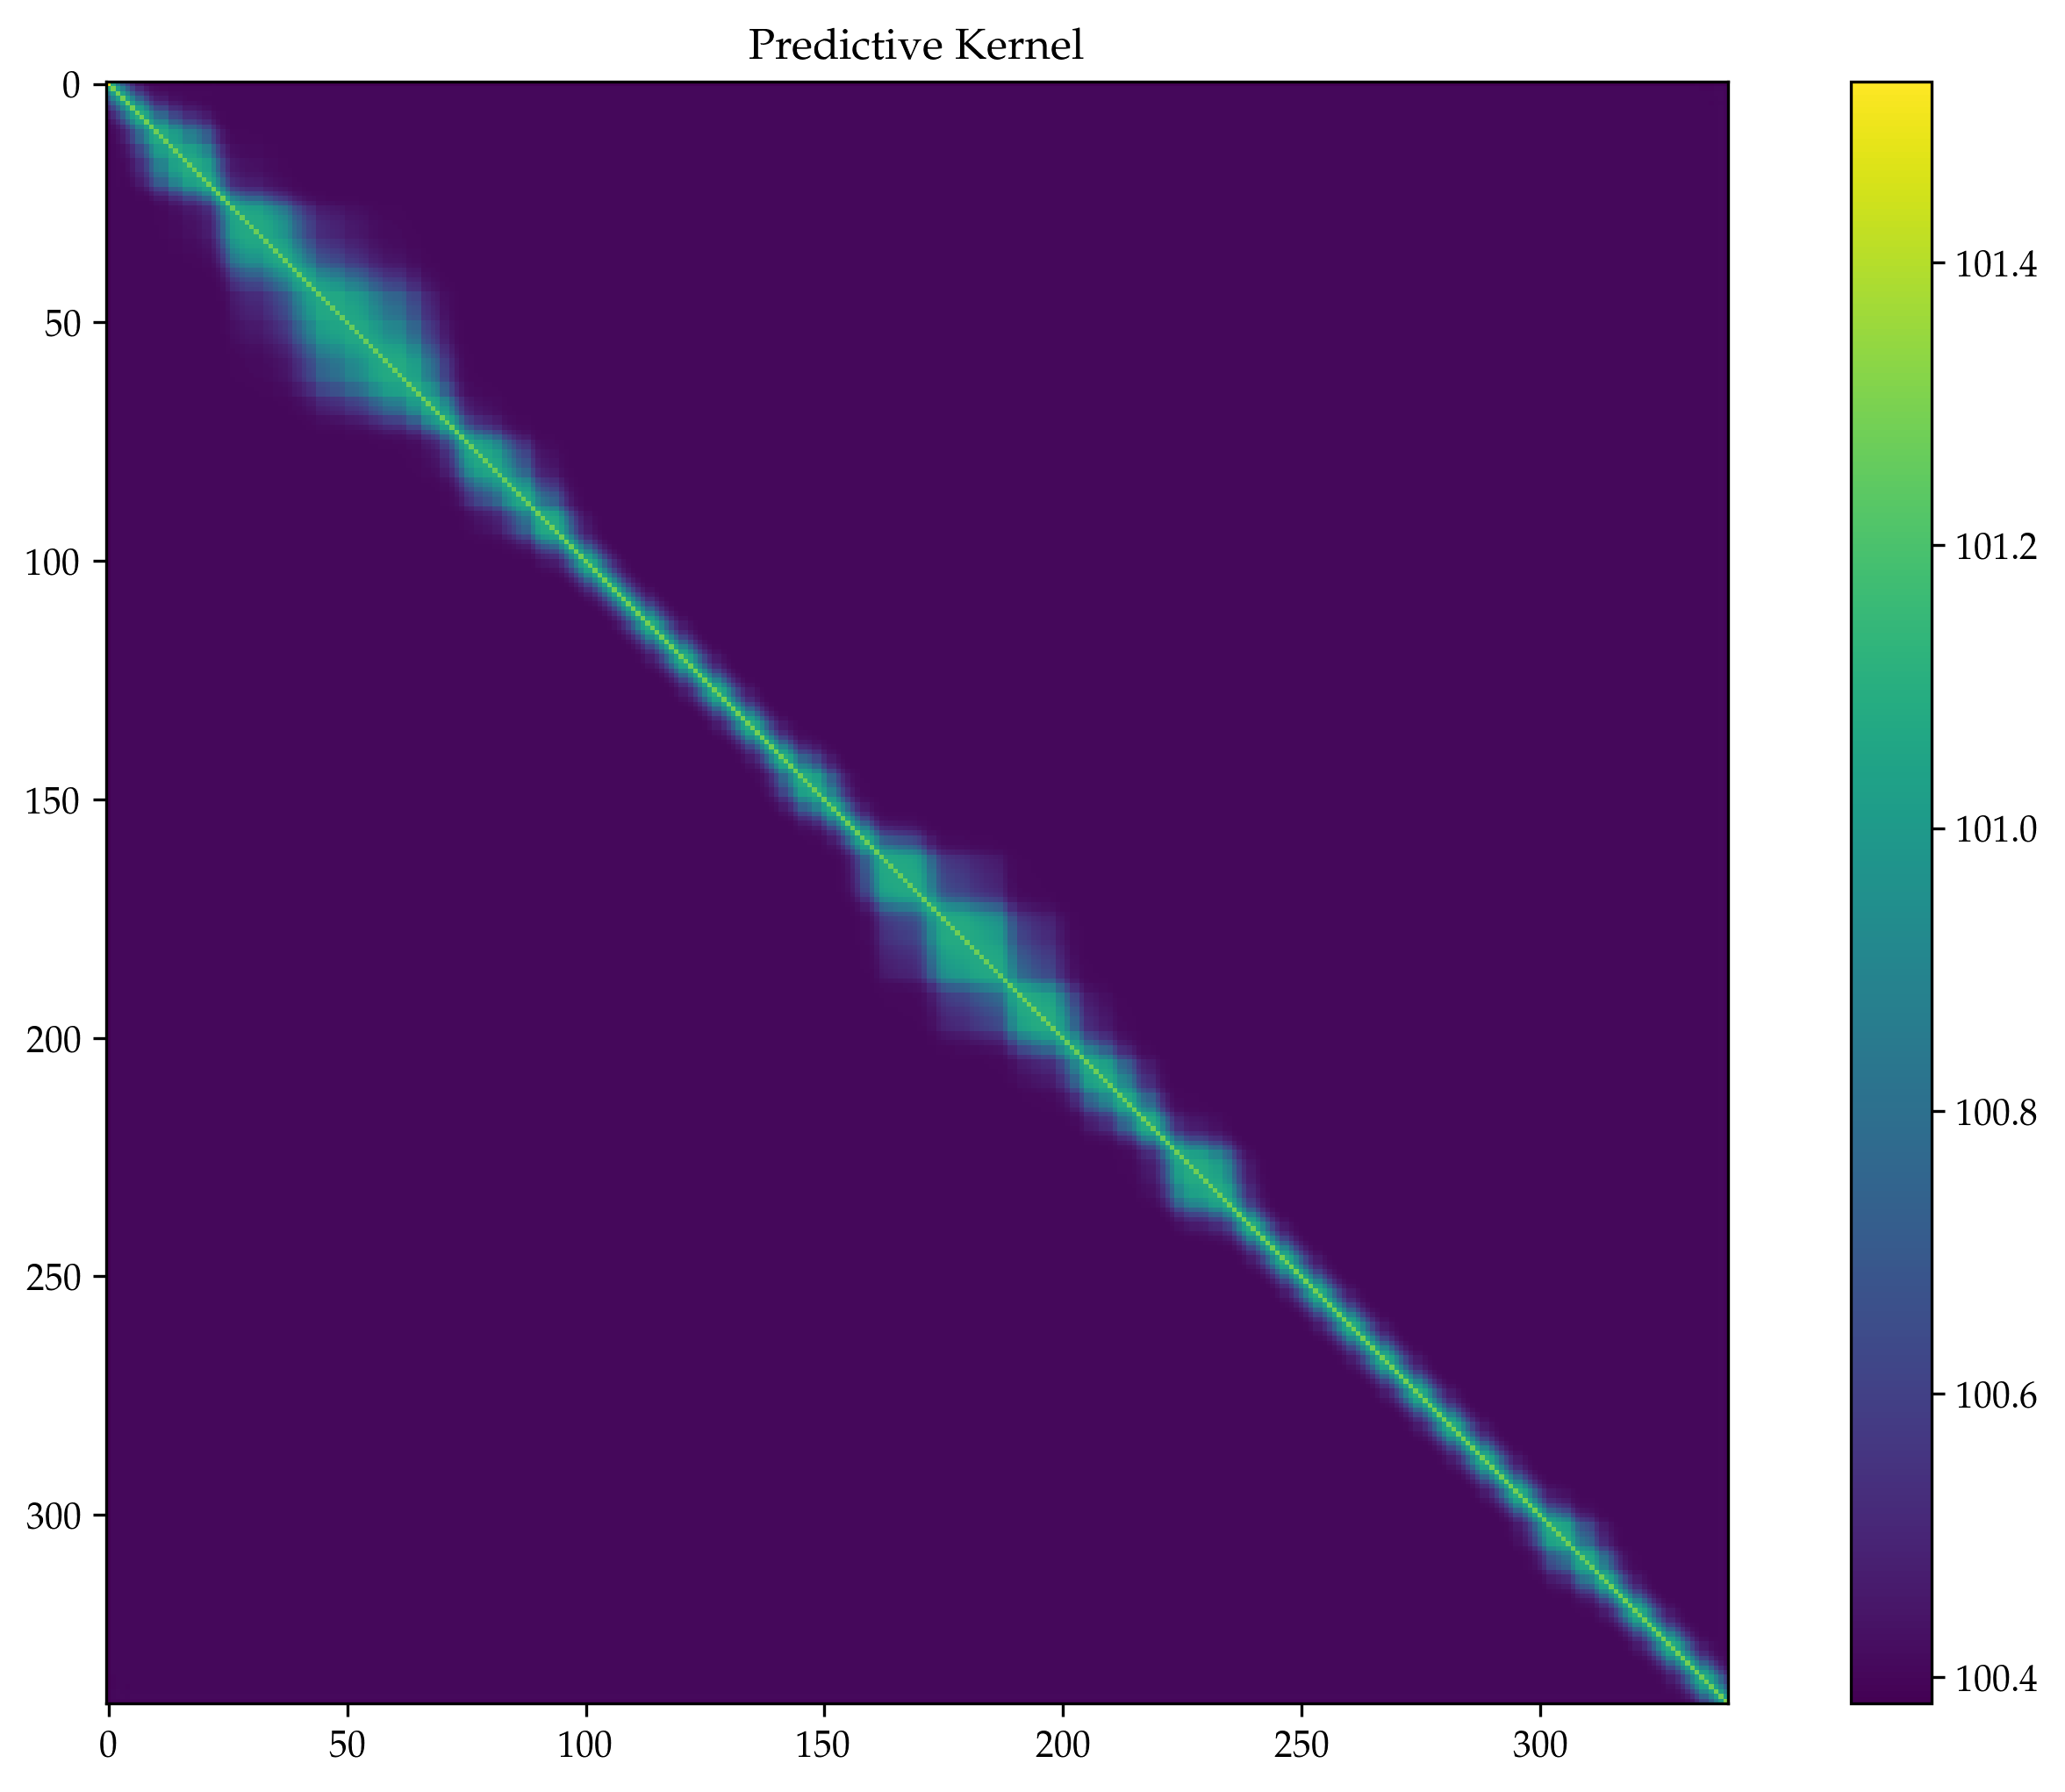

PyObject <matplotlib.colorbar.Colorbar object at 0x133931240>

In [13]:
begin
    plt.imshow(test_prediction[2].mat)
    plt.title("Predictive Kernel")
    plt.colorbar()
end

## Predictive draws

Let's show some draws from the posterior fitted using the hourly data at nearby stations, but *not* the $T_n$ and $T_x$ records.

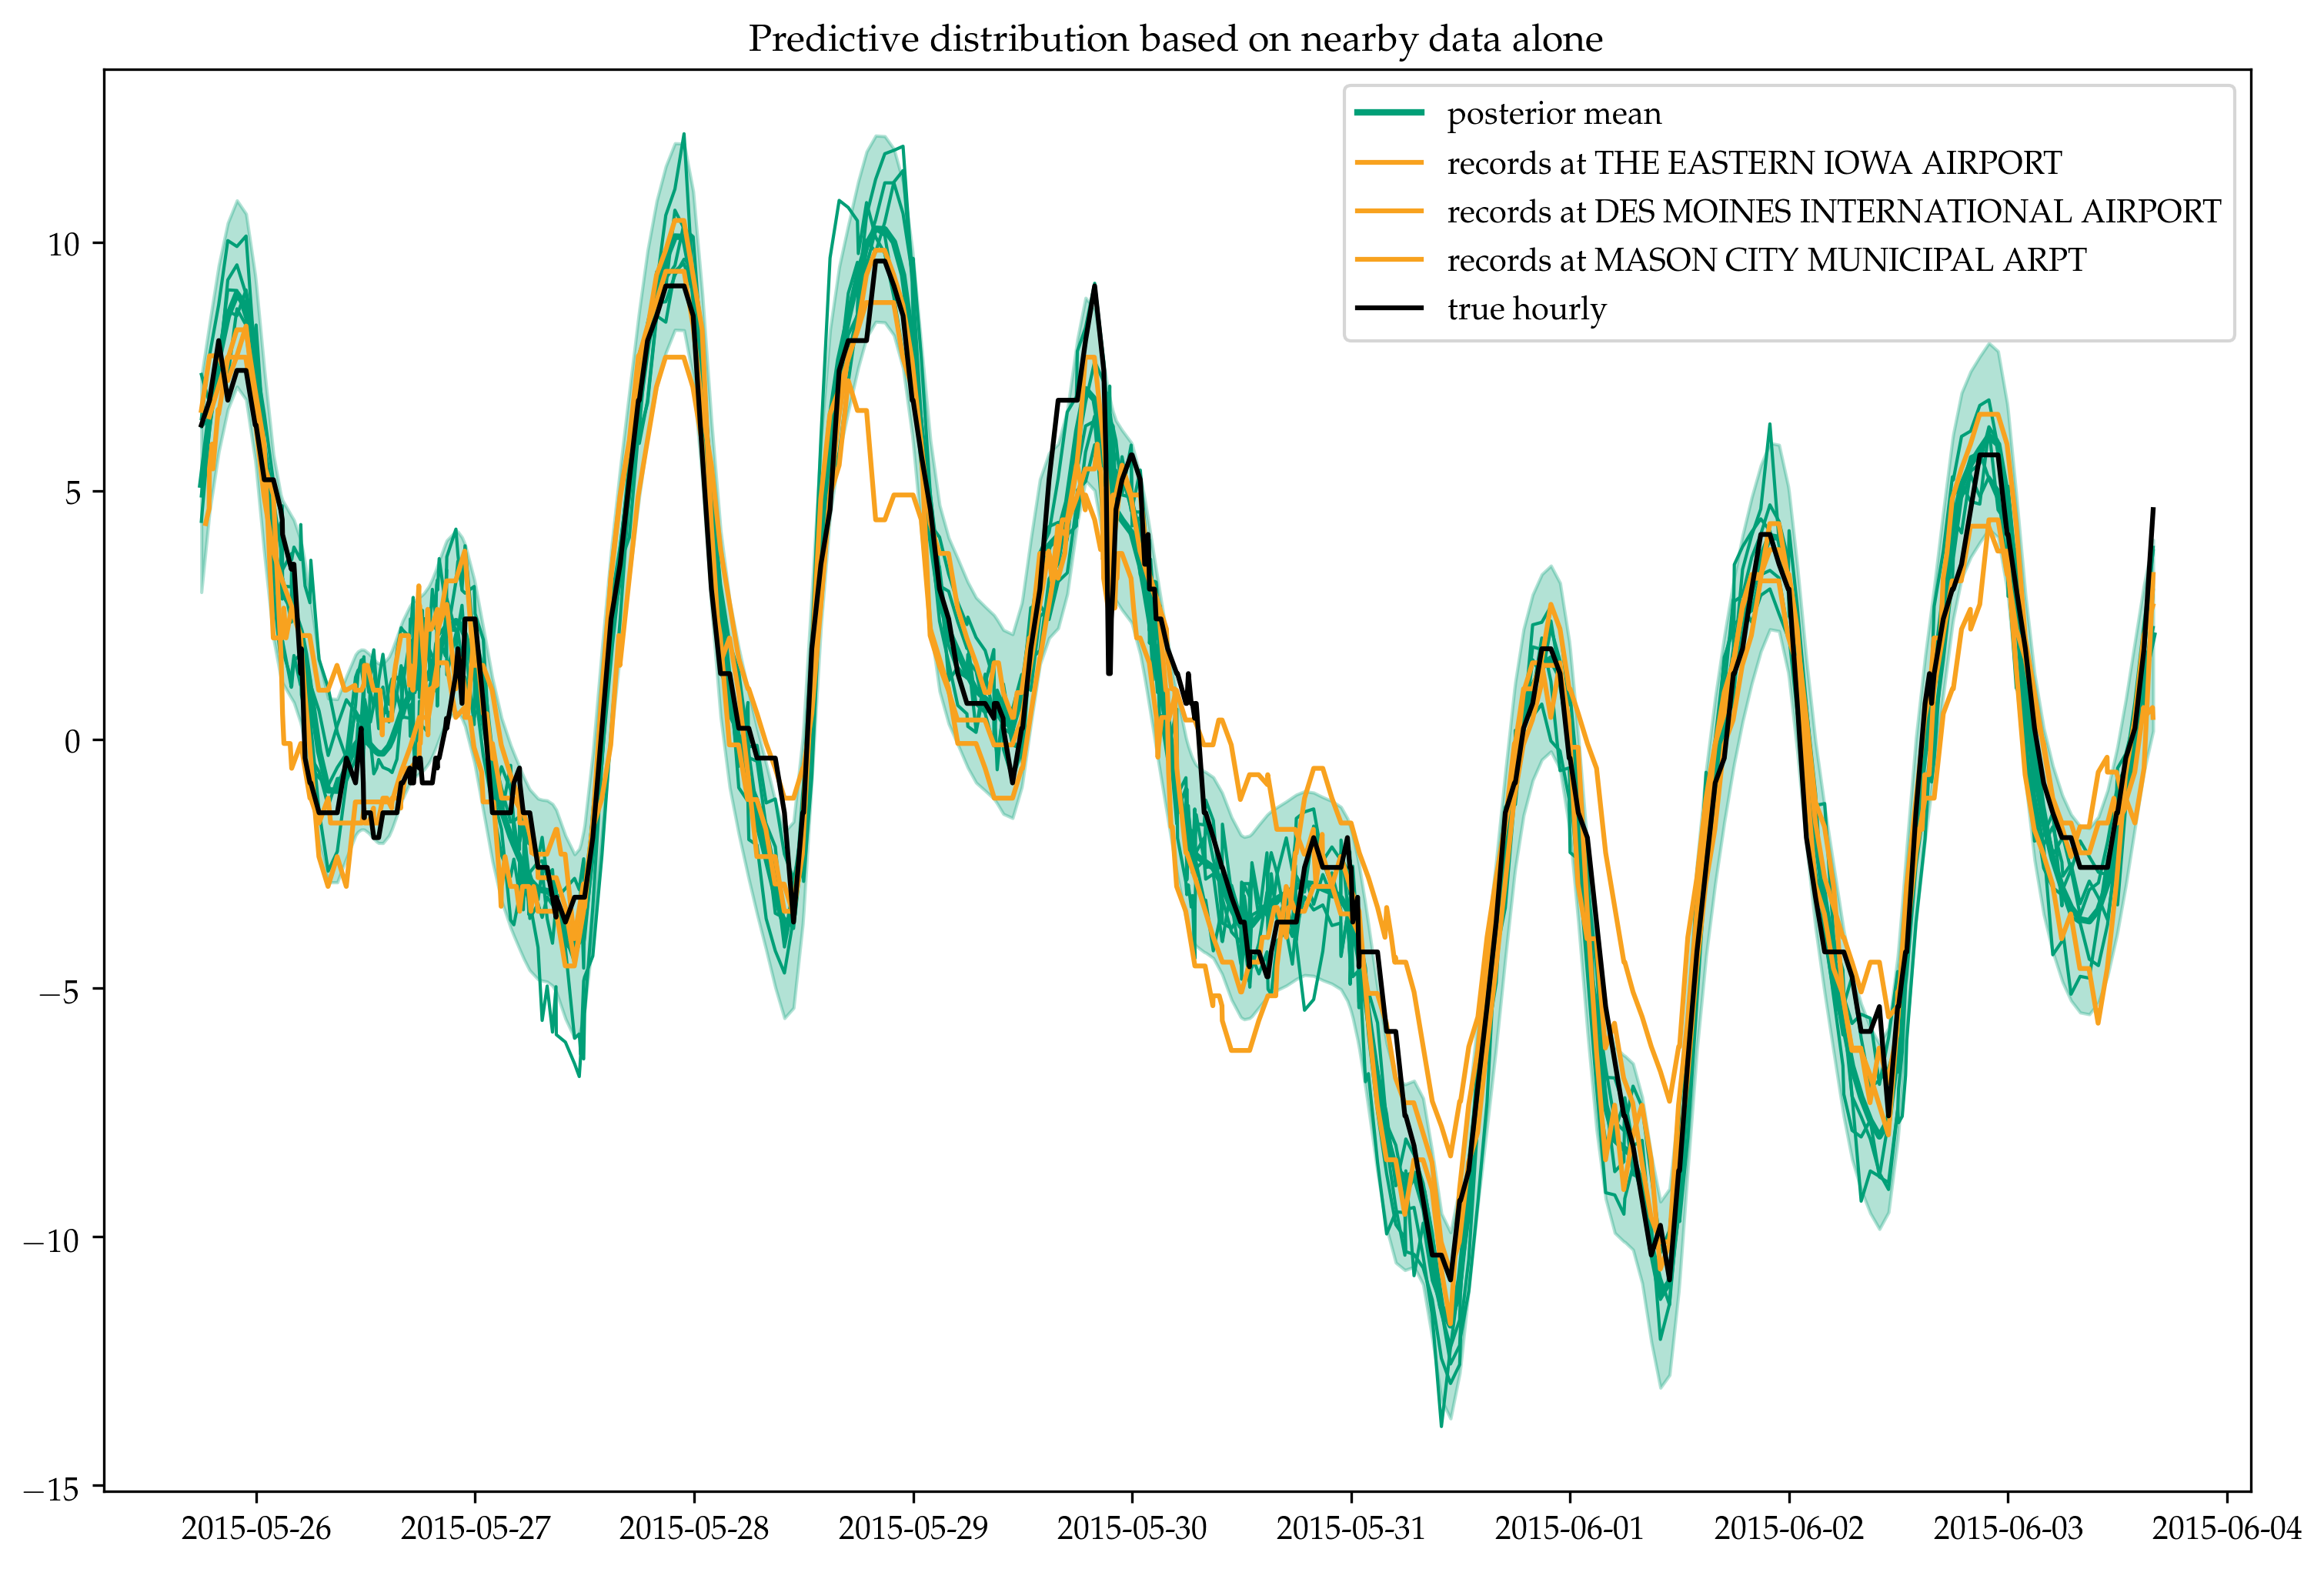

In [21]:
begin
    ts=test_subset[:ts]
    μ = test_prediction[1]
    Σ = test_prediction[2]
    nobsv = length(μ)
    
    centering = Matrix(1.0I, nobsv, nobsv) .- (1.0/nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:5
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    y_err = sqrt.(diag(Σ_centered))
    plt.fill_between(ts, μ-2*y_err,μ+2*y_err, color="#009F77", alpha=0.3)
    for station in unique(train_subset[:station])
        sdata = train_subset[train_subset[:station].==station,:]
        ts=sdata[:ts]
        plt.plot(ts, sdata[:temp].-mean(sdata[:temp]), color="#F8A21F", 
            label=string("records at", " ", iowa[:isdSubset][station,:NAME]))
    end
    ts = test_subset[:ts]
    temp_true = test_subset[:temp]
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
end
;

It's interesting to note that the posterior mean is quite close to the truth, despite the very wide credible envelope. To me this suggests that the information available from nearby stations is underweighted. We should be making more confident predictions.

# Specifying STAN model

In [31]:
function get_imputation_model(; pdir=pwd())
    imputation_model = """
        functions {
            real smoothmax(vector x, real k, real maxkx){
                return (maxkx+log(sum(exp(k*x - maxkx))))/k;
            }
            real smoothmin(vector x, real k, real minkx){
                return -smoothmax(-x, k, -minkx);
            }
        }
        data {
            // Tn Tx data
            int<lower=1> N_TxTn; //
            vector[N_TxTn] Tx;
            vector[N_TxTn] Tn;

            // imputation points (for which we have )
            int<lower=1> Nimpt;
            int<lower=1,upper=N_TxTn> day_impute[Nimpt];
            // number of hours recorded within each day
            int<lower=1> impt_times_p_day[N_TxTn];

            // prior 
            vector[Nimpt] predicted_mean;
            matrix[Nimpt,Nimpt] predicted_cov;
            cholesky_factor_cov[Nimpt,Nimpt] predicted_cov_chol;

            // control smooth max hardness
            real<lower=0> k_smoothmax;
            real<lower=0> epsilon;
        }
        parameters {
            vector[Nimpt] temp_impt;
        }
        transformed parameters {
            real Tsmoothmax[N_TxTn];
            real Tsmoothmin[N_TxTn];  
            
            {
                int istart;
                istart = 1;
                for (i in 1:N_TxTn){
                    int ntimes;
                    ntimes = impt_times_p_day[i];
                    Tsmoothmin[i] = smoothmin(segment(temp_impt,istart,ntimes), 
                                              k_smoothmax, 
                                              k_smoothmax*Tn[i]);
                    Tsmoothmax[i] = smoothmax(segment(temp_impt,istart,ntimes), 
                                              k_smoothmax,
                                              k_smoothmax*Tx[i]);
                    istart = istart + ntimes;
                }
            }
        }
        model {
            // temp_impt = predicted_mean + predicted_cov_chol*w_uncorr;
            temp_impt ~ multi_normal_cholesky(predicted_mean, predicted_cov_chol);
            Tn ~ normal(Tsmoothmin, epsilon);
            Tx ~ normal(Tsmoothmax, epsilon);
        }
    """
    stanmodel = Stanmodel(;
            name="imputationchol", 
            model=imputation_model, 
            pdir=pdir, 
        )
    return stanmodel
end

imputation_model = get_imputation_model()
;

=====> /usr/local/Cellar/cmdstan/2.17.0


File /usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol.stan will be updated.



## preparing Stan data

In [32]:
test_TxTn = by(test_subset, :ts_day, df -> DataFrame(
    Tn=first(df[:Tn]), 
    Tx=first(df[:Tx]), 
    times_p_day=nrow(df),
))

,ts_day,Tn,Tx,times_p_day
,Date,Float64,Float64,Int64
1,2015-05-26,15.6,25.6,46
2,2015-05-27,13.9,22.8,54
3,2015-05-28,13.9,26.7,27
4,2015-05-29,16.7,27.2,31
5,2015-05-30,12.8,26.7,59
6,2015-05-31,6.7,16.1,36
7,2015-06-01,6.7,19.4,28
8,2015-06-02,10.0,21.7,32
9,2015-06-03,15.0,23.9,27


In [33]:
ts_day = test_subset[:ts_day]
day_impute = Int.( (ts_day .- minimum(ts_day)) ./ Day(1) ) .+ 1
imputation_data = Dict(
    "N_TxTn" => nrow(test_TxTn),
    "Tn" => test_TxTn[:Tn],
    "Tx" => test_TxTn[:Tx],
    "Nimpt" => nrow(test_subset),
    "day_impute" => day_impute,
    "impt_times_p_day" => test_TxTn[:times_p_day],
    "predicted_mean" => test_prediction[1],
    "predicted_cov" => test_prediction[2].mat,
    "predicted_cov_chol" => Matrix(test_prediction[2].chol.L),
    "k_smoothmax" => 20.0,
    "epsilon" => 0.01,
    
)

Dict{String,Any} with 11 entries:
  "impt_times_p_day"   => [46, 54, 27, 31, 59, 36, 28, 32, 27]
  "Tx"                 => [25.6, 22.8, 26.7, 27.2, 26.7, 16.1, 19.4, 21.7, 23.9]
  "predicted_mean"     => [5.13124, 6.48653, 7.66563, 8.52217, 8.97763, 8.71283…
  "predicted_cov_chol" => [10.0761 0.0 … 0.0 0.0; 10.032 0.809551 … 0.0 0.0; … …
  "Nimpt"              => 340
  "day_impute"         => [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  9, 9, 9, 9, 9, 9, 9…
  "predicted_cov"      => [101.528 101.084 … 100.388 100.381; 101.084 101.297 ……
  "k_smoothmax"        => 20.0
  "epsilon"            => 0.01
  "Tn"                 => [15.6, 13.9, 13.9, 16.7, 12.8, 6.7, 6.7, 10.0, 15.0]
  "N_TxTn"             => 9

# Running STAN

In [34]:
@time sim1 = stan(imputation_model, [imputation_data], summary=false, diagnostics=false);



--- Translating Stan model to C++ code ---
bin/stanc  /usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol.stan --o=/usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol.hpp
Model name=imputationchol_model
Input file=/usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol.stan
Output file=/usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -I src -I stan/src -isystem stan/lib/stan_math/ -DEIGEN_NO_DEBUG -DFUSION_MAX_VECTOR_SIZE=12 -stdlib=libc++ -Wno-unknown-warning-option -Wno-unused-function -Wno-tautological-compare -Wsign-compare -DNO_FPRINTF_OUTPUT -pipe   -O3 -o /usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol src/cmdstan/main.cpp -include /usr/local/Cellar/cmdstan/2.17.0/tmp

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol.stan' at line 57)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol.stan' at line 57)


If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
but if this warning occurs often then your model may be either severely ill-conditioned or misspecifi

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol.stan' at line 56)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/usr/local/Cellar/cmdstan/2.17.0/tmp/imputationchol.stan' at line 56)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspec

393.278196 seconds (9.86 M allocations: 455.226 MiB, 0.03% gc time)


In [35]:
using MCMCChain
chains=Chains(sim1[2]; names=sim1[3]);

In [36]:
gelmandiag(chains)

Add `using LinearAlgebra` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using LinearAlgebra` to your imports.
  likely near /Users/imolk/Library/Julia/packages/IJulia/8Y05k/src/kernel.jl:41
Add `using Linea

                    PSRF          97.5%   
         lp__   3.6340000×10⁰  6.21500×10⁰
accept_stat__   1.0050000×10⁰  1.01400×10⁰
   stepsize__ 4.00352857×10¹² 9.73205×10¹²
  treedepth__   1.0400000×10⁰  1.10300×10⁰
 n_leapfrog__   1.0260000×10⁰  1.07100×10⁰
  divergent__             NaN          NaN
     energy__   2.6990000×10⁰  4.46100×10⁰
  temp_impt.1   1.0170000×10⁰  1.05300×10⁰
  temp_impt.2   1.0160000×10⁰  1.04900×10⁰
  temp_impt.3   1.0120000×10⁰  1.03600×10⁰
  temp_impt.4   1.0060000×10⁰  1.01800×10⁰
  temp_impt.5   1.0010000×10⁰  1.00300×10⁰
  temp_impt.6   1.0000000×10⁰  1.00100×10⁰
  temp_impt.7   1.0040000×10⁰  1.01100×10⁰
  temp_impt.8   1.0060000×10⁰  1.01700×10⁰
  temp_impt.9   1.0100000×10⁰  1.03000×10⁰
 temp_impt.10   1.0150000×10⁰  1.04500×10⁰
 temp_impt.11   1.0170000×10⁰  1.05300×10⁰
 temp_impt.12   1.0190000×10⁰  1.05800×10⁰
 temp_impt.13   1.0180000×10⁰  1.05200×10⁰
 temp_impt.14   1.0170000×10⁰  1.05100×10⁰
 temp_impt.15   1.0170000×10⁰  1.05200×10⁰
 temp_impt.

Some of these convergence diagnostics are quite bad!